In [1]:
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from eval import eval_net
from unet import UNet

from torch.utils.tensorboard import SummaryWriter
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split

from apex import amp
from memory import _add_memory_hooks
from plot import plot_mem, pp
import pandas as pd

dir_img = 'data/imgs/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'



def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=0.5):

    dataset = BasicDataset(dir_img, dir_mask, img_scale)
    print(dataset)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images scaling:  {img_scale}
    ''')

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    if net.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1
                if global_step % (n_train // (1 * batch_size)) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)

        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('-e', '--epochs', metavar='E', type=int, default=5,
                        help='Number of epochs', dest='epochs')
    parser.add_argument('-b', '--batch-size', metavar='B', type=int, nargs='?', default=1,
                        help='Batch size', dest='batchsize')
    parser.add_argument('-l', '--learning-rate', metavar='LR', type=float, nargs='?', default=0.0001,
                        help='Learning rate', dest='lr')
    parser.add_argument('-f', '--load', dest='load', type=str, default=False,
                        help='Load model from a .pth file')
    parser.add_argument('-s', '--scale', dest='scale', type=float, default=0.5,
                        help='Downscaling factor of the images')
    parser.add_argument('-v', '--validation', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')

    return parser.parse_args()



INFO: Using device cuda
INFO: Network:
	3 input channels
	1 output channels (classes)
	Bilinear upscaling
INFO: Creating dataset with 64 examples


INFO: Starting training:
        Epochs:          1
        Batch size:      1
        Learning rate:   0.0001
        Training size:   58
        Validation size: 6
        Checkpoints:     True
        Device:          cuda
        Images scaling:  0.5
    
Epoch 1/1:   0%|          | 0/58 [00:00<?, ?img/s]/home/shpark/.local/lib/python3.8/site-packages/torch/cuda/memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
Validation round: 100%|██████████| 6/6 [00:01<00:00,  5.83batch/s]
                                                                  INFO: Validation Dice Coeff: 0.9553641776243845
Epoch 1/1: 100%|██████████| 58/58 [00:31<00:00,  1.82img/s, loss (batch)=0.115]
INFO: Checkpoint 1 saved !


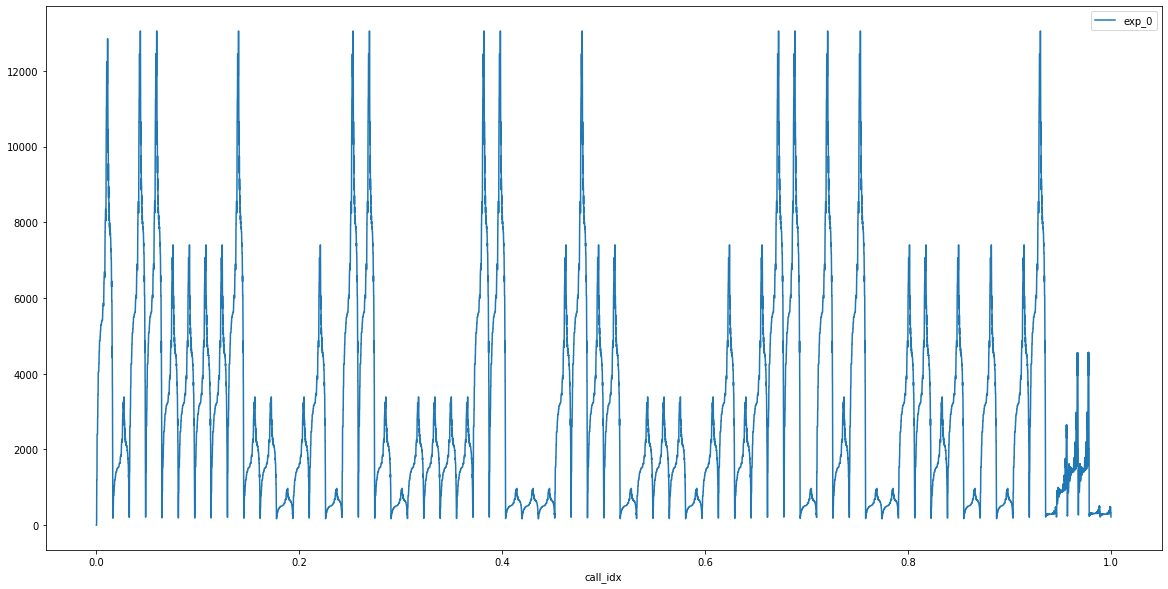

In [2]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
#   - For 1 class and background, use n_classes=1
#   - For 2 classes, use n_classes=1
#   - For N > 2 classes, use n_classes=N
net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.to(device=device)

logging.info(f'Network:\n'
             f'\t{net.n_channels} input channels\n'
             f'\t{net.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')



# if args.load:
#     net.load_state_dict(
#         torch.load(args.load, map_location=device)
#     )
#     logging.info(f'Model loaded from {args.load}')

# faster convolutions, but more memory
# cudnn.benchmark = True

mem_log = []
exp = f'exp_{len(mem_log)}'
hr = []
for idx, module in enumerate(net.modules()):
    _add_memory_hooks(idx, module, mem_log, exp, hr)
# [h.remove() for h in hr]
# print("MEM_LOG & HR: ", mem_log, hr)
# mem_logs = []
# mem_logs.extend(mem_log)

# try:
train_net(net=net,
              epochs=1,
              batch_size=args.batchsize,
              lr=args.lr,
              device=device,
              img_scale=args.scale,
              val_percent=args.val / 100)
    
# except KeyboardInterrupt:
#     torch.save(net.state_dict(), 'INTERRUPTED.pth')
#     logging.info('Saved interrupt')
#     try:
#         sys.exit(0)
#     except SystemExit:
#         os._exit(0)
        
df = pd.DataFrame(mem_log)
#         plot_mem(df, exps=['baseline'], output_file=f'./baseline_memory_plot.png')
df.to_csv('out.csv', index=False) 
plot_mem(df, output_file=f'./memory_plot.png')



In [22]:
mem_log = []
exp = f'exp_{len(mem_log)}'
hr = []
# for idx, module in enumerate(net.modules()):
#     _add_memory_hooks(idx, module, mem_log, exp, hr)
# [h.remove() for h in hr]

In [23]:

for idx, module in enumerate(net.modules()):
    _add_memory_hooks(idx, module, mem_log, exp, hr)

In [24]:
mem_log

[]

In [25]:
train_net(net=net,
          epochs=1,
          batch_size=args.batchsize,
          lr=args.lr,
          device=device,
          img_scale=args.scale,
          val_percent=args.val / 100)

INFO: Creating dataset with 16 examples
INFO: Starting training:
        Epochs:          1
        Batch size:      1
        Learning rate:   0.0001
        Training size:   15
        Validation size: 1
        Checkpoints:     True
        Device:          cuda
        Images scaling:  0.5
    
Validation round: 100%|██████████| 1/1 [00:00<00:00,  1.74batch/s]
                                                                  INFO: Validation Dice Coeff: 0.8807641863822937
Validation round: 100%|██████████| 1/1 [00:00<00:00,  1.83batch/s]
                                                                  INFO: Validation Dice Coeff: 0.8967970609664917
Validation round: 100%|██████████| 1/1 [00:00<00:00,  1.80batch/s]
                                                                  INFO: Validation Dice Coeff: 0.8487051725387573
Validation round: 100%|██████████| 1/1 [00:00<00:00,  1.74batch/s]
                                                                  INFO: Validation Dice Co

In [26]:
len(mem_log)

7125

In [20]:
    df = pd.DataFrame(mem_log)


In [ ]:
df

In [21]:
    plot_mem(df, output_file=f'./baseline_memory_plot.png')


AttributeError: 'DataFrame' object has no attribute 'exp'

In [6]:
dataset = BasicDataset(dir_img, dir_mask, 0.5)


INFO: Creating dataset with 16 examples


In [37]:
dataset[3]['image'].size()

torch.Size([3, 640, 959])